FER2013 - CNN

In [1]:
# import tarfile


# fname = 'fer2013.tar.gz'
# if fname.endswith("tar.gz"):
#     tar = tarfile.open(fname, "r:gz")
#     tar.extractall()
#     tar.close()
# elif fname.endswith("tar"):
#     tar = tarfile.open(fname, "r:")
#     tar.extractall()
#     tar.close()

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
df = pd.read_csv('C:/Kecilin/emotion_detection/V1/fer2013/fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'} 

In [5]:
img_array = df.pixels.apply(lambda x: np.array(x.split(" ")).reshape(48,48,1).astype('float32'))
img_array = np.stack(img_array, axis=0)
labels = df.emotion.values

In [6]:
img_array.shape

(35887, 48, 48, 1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(img_array, labels, test_size= .2)

In [8]:
y_train[0]

3

In [9]:
X_train = X_train/255
X_test = X_test/255

In [10]:
# datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
# )
# datagen.fit(X_train)

In [11]:
basemodel = tf.keras.models.Sequential([
                                        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
                                        tf.keras.layers.MaxPool2D(2, 2),
                                        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                                        tf.keras.layers.MaxPool2D(2, 2),
                                        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
                                        tf.keras.layers.MaxPool2D(2, 2),
                                        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                                        tf.keras.layers.MaxPool2D(2, 2),
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                                        tf.keras.layers.Dropout(0.5),
                                        tf.keras.layers.Dense(7, activation='softmax')
])

In [12]:
basemodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)         0

In [13]:
initial_learning_rate = 0.0001  # You can adjust this value
optimizer = tf.keras.optimizers.RMSprop(learning_rate=initial_learning_rate)
basemodel.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [14]:
def lr_schedule(epoch):
    if epoch < 20:
        return initial_learning_rate
    else:
        return initial_learning_rate * 0.1

In [15]:
# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

In [16]:
file_name = 'best_model.h5'
checkpoint_path= os.path.join('checkpoint',file_name)


call_back = [
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                        monitor='val_accuracy',
                                        verbose=1,
                                        save_freq='epoch',
                                        save_best_only=True,
                                        save_weights_only=False,
                                        mode='max'),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.LearningRateScheduler(lr_schedule)
]

In [17]:
# history = basemodel.fit(datagen.flow(X_train, y_train, batch_size=32),
#                         epochs=40,
#                         validation_data=(X_test, y_test),
#                         callbacks=call_back)

history = basemodel.fit(X_train, y_train,
                        epochs=60,
                        validation_split=.15,
                        callbacks=call_back)

Epoch 1/60
762/763 [============================>.] - ETA: 0s - loss: 2.1633 - accuracy: 0.2166
Epoch 1: val_accuracy improved from -inf to 0.25261, saving model to checkpoint\best_model.h5
763/763 [==============================] - 57s 71ms/step - loss: 2.1632 - accuracy: 0.2165 - val_loss: 2.0112 - val_accuracy: 0.2526 - lr: 1.0000e-04
Epoch 2/60
  1/763 [..............................] - ETA: 54s - loss: 2.0507 - accuracy: 0.0938

C:\Users\vince\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


763/763 [==============================] - ETA: 0s - loss: 1.9584 - accuracy: 0.2259
Epoch 2: val_accuracy did not improve from 0.25261
763/763 [==============================] - 46s 61ms/step - loss: 1.9584 - accuracy: 0.2259 - val_loss: 1.8801 - val_accuracy: 0.2526 - lr: 1.0000e-04
Epoch 3/60
763/763 [==============================] - ETA: 0s - loss: 1.8759 - accuracy: 0.2381
Epoch 3: val_accuracy improved from 0.25261 to 0.25772, saving model to checkpoint\best_model.h5
763/763 [==============================] - 37s 49ms/step - loss: 1.8759 - accuracy: 0.2381 - val_loss: 1.8363 - val_accuracy: 0.2577 - lr: 1.0000e-04
Epoch 4/60
763/763 [==============================] - ETA: 0s - loss: 1.8396 - accuracy: 0.2522
Epoch 4: val_accuracy improved from 0.25772 to 0.27653, saving model to checkpoint\best_model.h5
763/763 [==============================] - 37s 49ms/step - loss: 1.8396 - accuracy: 0.2522 - val_loss: 1.7939 - val_accuracy: 0.2765 - lr: 1.0000e-04
Epoch 5/60
762/763 [========

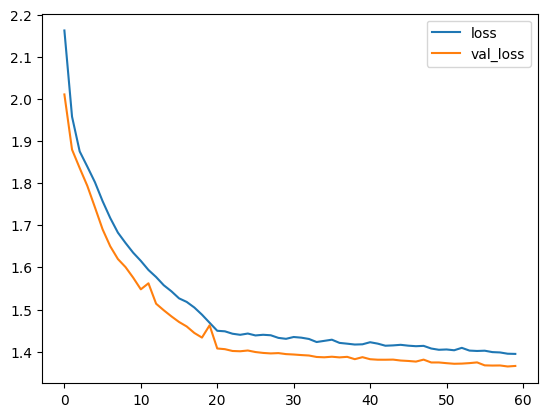

In [18]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

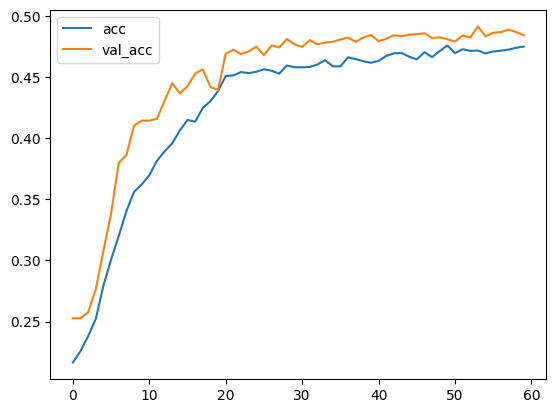

In [19]:
# Plot accuracy per iteration
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

225/225 [==============================] - 3s 11ms/step
Confusion matrix, without normalization
[[ 240    0   94  128  236   63  217]
 [  41    0   13   15   23    9   18]
 [ 115    0  130  101  222  204  200]
 [  51    0   36 1434  122   49  127]
 [ 114    0  112  141  481   56  386]
 [  10    0   56   54   31  558   65]
 [  59    0   69  147  204   45  702]]


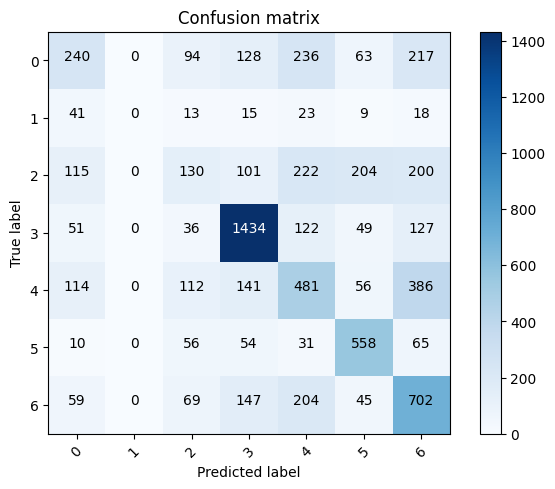

In [20]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


p_test = basemodel.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(7)))

In [21]:
checkpoint_path

'checkpoint\\best_model.h5'

actual label is surprise
1/1 [==============================] - 0s 22ms/step
predicted label is surprise


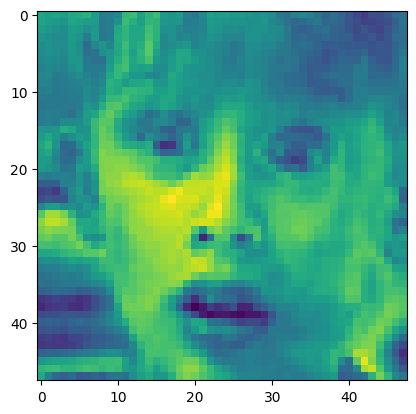

In [22]:
final_model = tf.keras.models.load_model(checkpoint_path)
from IPython.display import clear_output
import time

for k in range(40):
        print(f'actual label is {label_to_text[y_test[k]]}')
        predicted_class = final_model.predict(tf.expand_dims(X_test[k],0)).argmax()
        print(f'predicted label is {label_to_text[predicted_class]}')
        plt.imshow(X_test[k].reshape((48,48)))
        plt.show()
        time.sleep(3)
        clear_output(wait=True)